# Convolutional Neural Networks
(c) Deniz Yuret, 2018

* Objectives: See the effect of sparse and shared weights implemented by convolutional networks.
* Prerequisites: MLP models (04.mlp.ipynb), KnetArray, param, param0, dropout, relu, nll
* Knet: conv4, pool, mat (explained)
* Knet: dir, gpu, minibatch, KnetArray (used by mnist.jl)
* Knet: SGD, train!, Train, load, save (used by trainresults)

In [2]:
using Pkg
for p in ("Knet","Plots")
    haskey(Pkg.installed(),p) || Pkg.add(p)
end

## Introduction to convolution

In [3]:
# Convolution operator in Knet
using Knet: conv4
@doc conv4

```
conv4(w, x; kwargs...)
```

Execute convolutions or cross-correlations using filters specified with `w` over tensor `x`.

Currently KnetArray{Float32/64,4/5} and Array{Float32/64,4} are supported as `w` and `x`.  If `w` has dimensions `(W1,W2,...,I,O)` and `x` has dimensions `(X1,X2,...,I,N)`, the result `y` will have dimensions `(Y1,Y2,...,O,N)` where

```
Yi=1+floor((Xi+2*padding[i]-Wi)/stride[i])
```

Here `I` is the number of input channels, `O` is the number of output channels, `N` is the number of instances, and `Wi,Xi,Yi` are spatial dimensions.  `padding` and `stride` are keyword arguments that can be specified as a single number (in which case they apply to all dimensions), or an array/tuple with entries for each spatial dimension.

# Keywords

  * `padding=0`: the number of extra zeros implicitly concatenated at the start and at the end of each dimension.
  * `stride=1`: the number of elements to slide to reach the next filtering window.
  * `upscale=1`: upscale factor for each dimension.
  * `mode=0`: 0 for convolution and 1 for cross-correlation.
  * `alpha=1`: can be used to scale the result.
  * `handle`: handle to a previously created cuDNN context. Defaults to a Knet allocated handle.


In [4]:
# Convolution in 1-D
@show w = reshape([1.0,2.0,3.0], (3,1,1,1))
@show x = reshape([1.0:7.0...], (7,1,1,1))
@show y = conv4(w, x);  # size Y = X - W + 1 = 5 by default

w = reshape([1.0, 2.0, 3.0], (3, 1, 1, 1)) = [1.0; 2.0; 3.0]
x = reshape([1.0:7.0...], (7, 1, 1, 1)) = [1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0]
y = conv4(w, x) = [10.0; 16.0; 22.0; 28.0; 34.0]


In [5]:
# Padding
@show y2 = conv4(w, x, padding=(1,0));  # size Y = X + 2P - W + 1 = 7 with padding=1
# To preserve input size (Y=X) for a given W, what padding P should we use?

y2 = conv4(w, x, padding=(1, 0)) = [4.0; 10.0; 16.0; 22.0; 28.0; 34.0; 32.0]


In [6]:
# Stride
@show y3 = conv4(w, x; padding=(1,0), stride=3);  # size Y = 1 + floor((X+2P-W)/S)

y3 = conv4(w, x; padding=(1, 0), stride=3) = [4.0; 22.0; 32.0]


In [7]:
# Mode
@show y4 = conv4(w, x, mode=0);  # Default mode (convolution) inverts w
@show y5 = conv4(w, x, mode=1);  # mode=1 (cross-correlation) does not invert w

y4 = conv4(w, x, mode=0) = [10.0; 16.0; 22.0; 28.0; 34.0]
y5 = conv4(w, x, mode=1) = [14.0; 20.0; 26.0; 32.0; 38.0]


In [8]:
# Convolution in more dimensions
x = reshape([1.0:9.0...], (3,3,1,1))

3×3×1×1 Array{Float64,4}:
[:, :, 1, 1] =
 1.0  4.0  7.0
 2.0  5.0  8.0
 3.0  6.0  9.0

In [9]:
w = reshape([1.0:4.0...], (2,2,1,1))

2×2×1×1 Array{Float64,4}:
[:, :, 1, 1] =
 1.0  3.0
 2.0  4.0

In [10]:
y = conv4(w, x)

2×2×1×1 Array{Float64,4}:
[:, :, 1, 1] =
 23.0  53.0
 33.0  63.0

In [11]:
# Convolution with multiple channels, filters, and instances
# size X = [X1,X2,...,Xd,Cx,N] where d is the number of dimensions, Cx is channels, N is instances
x = reshape([1.0:18.0...], (3,3,2,1)) 

3×3×2×1 Array{Float64,4}:
[:, :, 1, 1] =
 1.0  4.0  7.0
 2.0  5.0  8.0
 3.0  6.0  9.0

[:, :, 2, 1] =
 10.0  13.0  16.0
 11.0  14.0  17.0
 12.0  15.0  18.0

In [12]:
# size W = [W1,W2,...,Wd,Cx,Cy] where d is the number of dimensions, Cx is input channels, Cy is output channels
w = reshape([1.0:24.0...], (2,2,2,3));

In [13]:
# size Y = [Y1,Y2,...,Yd,Cy,N]  where Yi = 1 + floor((Xi+2Pi-Wi)/Si), Cy is channels, N is instances
y = conv4(w,x)

2×2×3×1 Array{Float64,4}:
[:, :, 1, 1] =
 328.0  436.0
 364.0  472.0

[:, :, 2, 1] =
 808.0  1108.0
 908.0  1208.0

[:, :, 3, 1] =
 1288.0  1780.0
 1452.0  1944.0

See http://cs231n.github.io/assets/conv-demo/index.html for an animated example.

## Introduction to Pooling

In [14]:
# Pooling operator in Knet
using Knet: pool
@doc pool

```
pool(x; kwargs...)
```

Compute pooling of input values (i.e., the maximum or average of several adjacent values) to produce an output with smaller height and/or width.

Currently 4 or 5 dimensional KnetArrays with `Float32` or `Float64` entries are supported.  If `x` has dimensions `(X1,X2,...,I,N)`, the result `y` will have dimensions `(Y1,Y2,...,I,N)` where

```
Yi=1+floor((Xi+2*padding[i]-window[i])/stride[i])
```

Here `I` is the number of input channels, `N` is the number of instances, and `Xi,Yi` are spatial dimensions.  `window`, `padding` and `stride` are keyword arguments that can be specified as a single number (in which case they apply to all dimensions), or an array/tuple with entries for each spatial dimension.

# Keywords:

  * `window=2`: the pooling window size for each dimension.
  * `padding=0`: the number of extra zeros implicitly concatenated at the start and at the end of each dimension.
  * `stride=window`: the number of elements to slide to reach the next pooling window.
  * `mode=0`: 0 for max, 1 for average including padded values, 2 for average excluding padded values.
  * `maxpoolingNanOpt=0`: Nan numbers are not propagated if 0, they are propagated if 1.
  * `alpha=1`: can be used to scale the result.
  * `handle`: Handle to a previously created cuDNN context. Defaults to a Knet allocated handle.


In [15]:
# 1-D pooling example
@show x = reshape([1.0:6.0...], (6,1,1,1))
@show pool(x);

x = reshape([1.0:6.0...], (6, 1, 1, 1)) = [1.0; 2.0; 3.0; 4.0; 5.0; 6.0]
pool(x) = [2.0; 4.0; 6.0]


In [16]:
# Window size
@show pool(x; window=3);  # size Y = floor(X/W)

pool(x; window=3) = [3.0; 6.0]


In [17]:
# Padding
@show pool(x; padding=(1,0));  # size Y = floor((X+2P)/W)

pool(x; padding=(1, 0)) = [1.0; 3.0; 5.0; 6.0]


In [18]:
# Stride
@show x = reshape([1.0:10.0...], (10,1,1,1));
@show pool(x; stride=4);  # size Y = 1 + floor((X+2P-W)/S)

x = reshape([1.0:10.0...], (10, 1, 1, 1)) = [1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0; 9.0; 10.0]
pool(x; stride=4) = [2.0; 6.0; 10.0]


In [19]:
# Mode (using KnetArray here; not all modes are implemented on the CPU)
using Knet: KnetArray
x = KnetArray(reshape([1.0:6.0...], (6,1,1,1)))
@show x
@show pool(x; padding=(1,0), mode=0)  # max pooling
@show pool(x; padding=(1,0), mode=1)  # avg pooling
@show pool(x; padding=(1,0), mode=2); # avg pooling excluding padded values (is not implemented on CPU)

x = [1.0; 2.0; 3.0; 4.0; 5.0; 6.0]
pool(x; padding=(1, 0), mode=0) = [1.0; 3.0; 5.0; 6.0]
pool(x; padding=(1, 0), mode=1) = [0.5; 2.5; 4.5; 3.0]
pool(x; padding=(1, 0), mode=2) = [1.0; 2.5; 4.5; 6.0]


In [20]:
# More dimensions
x = reshape([1.0:16.0...], (4,4,1,1))

4×4×1×1 Array{Float64,4}:
[:, :, 1, 1] =
 1.0  5.0   9.0  13.0
 2.0  6.0  10.0  14.0
 3.0  7.0  11.0  15.0
 4.0  8.0  12.0  16.0

In [21]:
pool(x)

2×2×1×1 Array{Float64,4}:
[:, :, 1, 1] =
 6.0  14.0
 8.0  16.0

In [22]:
# Multiple channels and instances
x = reshape([1.0:32.0...], (4,4,2,1))

4×4×2×1 Array{Float64,4}:
[:, :, 1, 1] =
 1.0  5.0   9.0  13.0
 2.0  6.0  10.0  14.0
 3.0  7.0  11.0  15.0
 4.0  8.0  12.0  16.0

[:, :, 2, 1] =
 17.0  21.0  25.0  29.0
 18.0  22.0  26.0  30.0
 19.0  23.0  27.0  31.0
 20.0  24.0  28.0  32.0

In [23]:
# each channel and each instance is pooled separately
pool(x)  # size Y = (Y1,...,Yd,Cx,N) where Yi are spatial dims, Cx and N are identical to input X

2×2×2×1 Array{Float64,4}:
[:, :, 1, 1] =
 6.0  14.0
 8.0  16.0

[:, :, 2, 1] =
 22.0  30.0
 24.0  32.0

## Experiment setup

In [24]:
# Load data (see 02.mnist.ipynb)
using Knet: Knet, KnetArray, gpu, minibatch
include(Knet.dir("data","mnist.jl"))  # Load data
dtrn,dtst = mnistdata();              # dtrn and dtst = [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100

┌ Info: Loading MNIST...
└ @ Main /data/scratch/deniz/.julia/dev/Knet/data/mnist.jl:33


In [25]:
(x,y) = first(dtst)
summary.((x,y))

("28×28×1×100 KnetArray{Float32,4}", "100-element Array{UInt8,1}")

In [26]:
# For running experiments
ENV["COLUMNS"]=92
using Knet: SGD, train!, Train
function trainresults(file,model,datasets...; optimizer=SGD(lr=0.1), whentorecord=0:600:60000, o...)
    if (print("Train from scratch? ");readline()[1]=='y')
        t = Train(whentorecord,datasets...)
        train!(model,datasets[1];callback=t,optimizer=optimizer,o...)
        t.datasets = t.progress = nothing 
        Knet.save(file,"results",t)
    end
    isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)    
    t = Knet.load(file,"results")
    println(minimum.([t.losses..., t.errors...]))
    return t
end;

## A convolutional neural network model for MNIST

In [27]:
# Redefine Linear layer (See 03.lin.ipynb):
using Knet: param, param0
struct Linear; w; b; end
(f::Linear)(x) = (f.w * mat(x) .+ f.b)
mat(x)=reshape(x,:,size(x)[end])  # Reshapes 4-D tensor to 2-D matrix so we can use matmul
Linear(inputsize::Int,outputsize::Int) = Linear(param(outputsize,inputsize),param0(outputsize))

Linear

In [28]:
# Define a convolutional layer:
struct Conv; w; b; end
(f::Conv)(x) = pool(conv4(f.w,x) .+ f.b)
Conv(w1,w2,cx,cy) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1))

Conv

In [29]:
# Define a convolutional neural network:
struct CNN; layers; end

In [30]:
# Weight initialization for a multi-layer convolutional neural network
# h[i] is an integer for a fully connected layer, a triple of integers for convolution filters and tensor inputs
# use CNN(x,h1,h2,...,hn,y) for a n hidden layer model
function CNN(h...)  
    w = Any[]
    x = h[1]
    for i=2:length(h)
        if isa(h[i],Tuple)
            (x1,x2,cx) = x
            (w1,w2,cy) = h[i]
            push!(w, Conv(w1,w2,cx,cy))
            x = ((x1-w1+1)÷2,(x2-w2+1)÷2,cy) # assuming conv4 with p=0, s=1 and pool with p=0,w=s=2
        elseif isa(h[i],Integer)
            push!(w, Linear(prod(x),h[i]))
            x = h[i]
        else
            error("Unknown layer type: $(h[i])")
        end
    end
    CNN(w)
end;

In [31]:
using Knet: dropout, relu
function (m::CNN)(x; pdrop=0)
    for (i,layer) in enumerate(m.layers)
        p = (i <= length(pdrop) ? pdrop[i] : pdrop[end])
        x = dropout(x, p)
        x = layer(x)
        x = (layer == m.layers[end] ? x : relu.(x))
    end
    return x
end

In [32]:
lenet = CNN((28,28,1), (5,5,20), (5,5,50), 500, 10)
summary.(l.w for l in lenet.layers)

4-element Array{String,1}:
 "5×5×1×20 Param{KnetArray{Float32,4}}" 
 "5×5×20×50 Param{KnetArray{Float32,4}}"
 "500×800 Param{KnetArray{Float32,2}}"  
 "10×500 Param{KnetArray{Float32,2}}"   

In [33]:
using Knet: nll
(x,y) = first(dtst)
nll(lenet,x,y)

2.2980886f0

## CNN vs MLP

In [34]:
@time cnn = trainresults("cnn.jld2", lenet, dtrn, dtst; pdrop=(0,0,.3)); # 406s [8.83583e-5, 0.017289, 0.0, 0.0048]

Train from scratch? stdin> n
[0.000149311, 0.0196784, 0.0, 0.005]
 13.132787 seconds (18.90 M allocations: 930.227 MiB, 4.86% gc time)


In [35]:
mlp = Knet.load("mlp.jld2","results");

In [51]:
using Plots; default(fmt=:png)

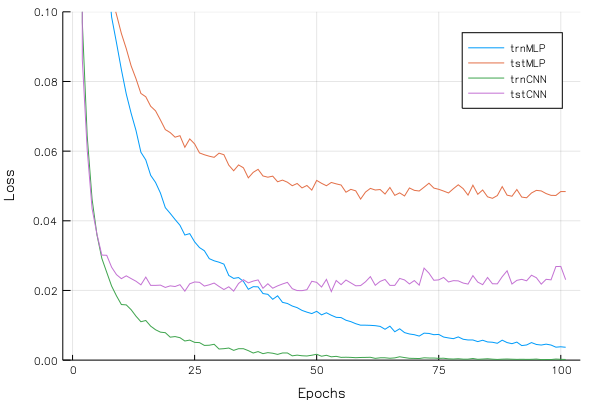

In [37]:
# Comparison to MLP shows faster convergence, better generalization
plot([mlp.losses[1], mlp.losses[2], cnn.losses[1], cnn.losses[2]],ylim=(0.0,0.1),
     labels=[:trnMLP :tstMLP :trnCNN :tstCNN],xlabel="Epochs",ylabel="Loss")  

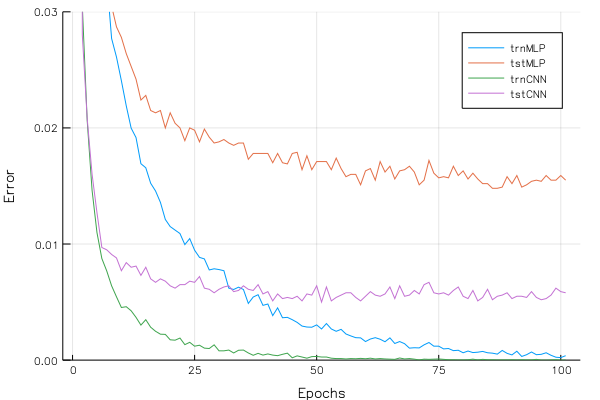

In [38]:
plot([mlp.errors[1], mlp.errors[2], cnn.errors[1], cnn.errors[2]],ylim=(0.0,0.03),
    labels=[:trnMLP :tstMLP :trnCNN :tstCNN],xlabel="Epochs",ylabel="Error")  

## Convolution vs Matrix Multiplication

In [39]:
# Convolution and matrix multiplication can be implemented in terms of each other.
# Convolutional networks have no additional representational power, only statistical efficiency.
# Our original 1-D example
@show w = reshape([1.0,2.0,3.0], (3,1,1,1))
@show x = reshape([1.0:7.0...], (7,1,1,1))
@show y = conv4(w, x);  # size Y = X - W + 1 = 5 by default

w = reshape([1.0, 2.0, 3.0], (3, 1, 1, 1)) = [1.0; 2.0; 3.0]
x = reshape([1.0:7.0...], (7, 1, 1, 1)) = [1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0]
y = conv4(w, x) = [10.0; 16.0; 22.0; 28.0; 34.0]


In [40]:
# Convolution as matrix multiplication (1)
# Turn w into a (Y,X) sparse matrix
w2 = Float64[3 2 1 0 0 0 0; 0 3 2 1 0 0 0; 0 0 3 2 1 0 0; 0 0 0 3 2 1 0; 0 0 0 0 3 2 1]

5×7 Array{Float64,2}:
 3.0  2.0  1.0  0.0  0.0  0.0  0.0
 0.0  3.0  2.0  1.0  0.0  0.0  0.0
 0.0  0.0  3.0  2.0  1.0  0.0  0.0
 0.0  0.0  0.0  3.0  2.0  1.0  0.0
 0.0  0.0  0.0  0.0  3.0  2.0  1.0

In [41]:
@show y2 = w2 * mat(x);

y2 = w2 * mat(x) = [10.0; 16.0; 22.0; 28.0; 34.0]


In [42]:
# Convolution as matrix multiplication (2)
# Turn x into a (W,Y) dense matrix (aka the im2col operation)
# This is used to speed up convolution with known efficient matmul algorithms
x3 = Float64[1 2 3 4 5; 2 3 4 5 6; 3 4 5 6 7]

3×5 Array{Float64,2}:
 1.0  2.0  3.0  4.0  5.0
 2.0  3.0  4.0  5.0  6.0
 3.0  4.0  5.0  6.0  7.0

In [43]:
@show w3 = [3.0 2.0 1.0]
@show y3 = w3 * x3;

w3 = [3.0 2.0 1.0] = [3.0 2.0 1.0]
y3 = w3 * x3 = [10.0 16.0 22.0 28.0 34.0]


In [44]:
# Matrix multiplication as convolution
# This could be used to make a fully connected network accept variable sized inputs.
w = reshape([1.0:6.0...], (2,3))

2×3 Array{Float64,2}:
 1.0  3.0  5.0
 2.0  4.0  6.0

In [45]:
x = reshape([1.0:3.0...], (3,1))

3×1 Array{Float64,2}:
 1.0
 2.0
 3.0

In [46]:
y = w * x

2×1 Array{Float64,2}:
 22.0
 28.0

In [47]:
# Consider w with size (Y,X)
# Treat each of the Y rows of w as a convolution filter
w2 = copy(reshape(Array(w)', (3,1,1,2)))

3×1×1×2 Array{Float64,4}:
[:, :, 1, 1] =
 1.0
 3.0
 5.0

[:, :, 1, 2] =
 2.0
 4.0
 6.0

In [48]:
# Reshape x for convolution
x2 = reshape(x, (3,1,1,1))

3×1×1×1 Array{Float64,4}:
[:, :, 1, 1] =
 1.0
 2.0
 3.0

In [49]:
# Use conv4 for matrix multiplication
y2 = conv4(w2, x2; mode=1)

1×1×2×1 Array{Float64,4}:
[:, :, 1, 1] =
 22.0

[:, :, 2, 1] =
 28.0

In [50]:
# So there is no difference between the class of functions representable with an MLP vs CNN.
# Sparse connections and weight sharing give CNNs more generalization power with images.
# Number of parameters in MLP256: (256x784)+256+(10x256)+10 = 203530
# Number of parameters in LeNet: (5*5*1*20)+20+(5*5*20*50)+50+(500*800)+500+(10*500)+10 = 431080